# Synthetic Example

In [42]:
# !pip install git+https://github.com/wayneweiqiang/GaMMA.git

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
from collections import defaultdict
from gamma import BayesianGaussianMixture, GaussianMixture

## 1. Prepare synthetic data

True events:
loc=400.000	t0=33.333
loc=1600.000	t0=93.333
loc=880.000	t0=153.333
loc=1360.000	t0=213.333
loc=1120.000	t0=273.333
loc=640.000	t0=333.333


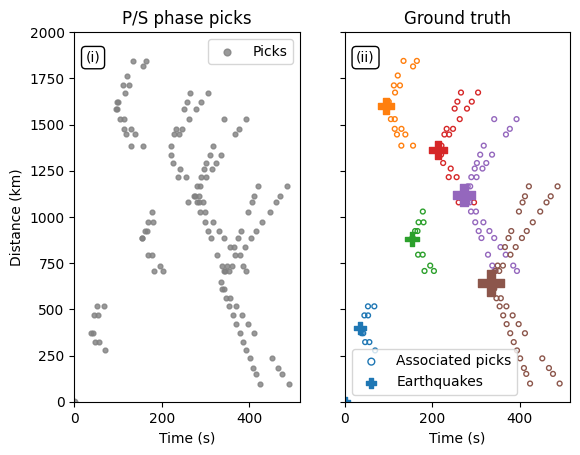

In [44]:
vp = 6.0
vs = vp/1.75
np.random.seed(1)

## small area
# use_amplitude = False
# num_event = 4
# num_station = 15
# xlim = [0, 200]

## large area
num_event = 6
num_station = 40
xlim = [0, 2000]
use_amplitude = True
phase_time_err = 0.0
phase_amp_err = 0.0
phase_fp_rate = 0.0

station_loc = np.linspace(xlim[0]+xlim[1]/20.0, xlim[1]-xlim[1]/20.0, num_station)[:, np.newaxis] + \
              np.random.uniform(low=-10, high=10, size=(num_station,1))
event_loc = np.linspace(xlim[0]+xlim[1]/5.0, xlim[1]-xlim[1]/5.0, num_event)[:, np.newaxis] + \
            np.random.uniform(low=-0, high=0, size=(num_event,1))
np.random.shuffle(event_loc)
event_t0 = np.linspace(xlim[1]/vp/10, xlim[1]/vp, num_event)
# np.random.shuffle(event_t0)
# event_mag = np.linspace(2, 5, num_event)
event_mag = np.logspace(np.log10(2), np.log10(3), num_event)
np.random.shuffle(event_mag)
print("True events:")
for i in range(num_event):
    if use_amplitude:
        print(f"loc={event_loc[i,0]:.3f}\tt0={event_t0[i]:.3f}\tmag={event_mag[i]:.3f}")
    else:
        print(f"loc={event_loc[i,0]:.3f}\tt0={event_t0[i]:.3f}")


phase_event_idx = []
phase_time = []
phase_amp = []
phase_type = []
phase_loc = []
c0, c1, c2, c3 = 1.08, 0.93, -0.015, -1.68
for i in range(num_event):
    loc = event_loc[i]
    t0 = event_t0[i]
    mag = event_mag[i]
    dist = np.abs(loc - station_loc)
    tp = t0 + dist / vp 
    ts = t0 + dist / vs 
    logA = c0 + c1*(mag-3.5) + c3*np.log10(dist)
    tp_err = np.random.uniform(low=-phase_time_err, high=phase_time_err, size=num_station)
    ts_err = np.random.uniform(low=-phase_time_err, high=phase_time_err, size=num_station)
    logA_p_err = np.random.uniform(low=-phase_amp_err, high=phase_amp_err, size=num_station)
    logA_s_err = np.random.uniform(low=-phase_amp_err, high=phase_amp_err, size=num_station)
    for j in range(num_station):
        if logA[j] > -4:
            if np.random.rand() < 0.8:
                phase_time.append(tp[j] + tp_err[j]) #p
                phase_amp.append(logA[j] + logA_p_err[j])
                phase_type.append("p")
                phase_loc.append(station_loc[j])
                phase_event_idx.append(i)
            if np.random.rand() < 0.8:
                phase_time.append(ts[j] + ts_err[j]) #s
                phase_amp.append(logA[j] + + logA_s_err[j])
                phase_type.append("s")
                phase_loc.append(station_loc[j])
                phase_event_idx.append(i)

np.random.seed(1)
min_phase_time, max_phase_time = min(phase_time), max(phase_time) 
min_phase_amp, max_phase_amp = min(phase_amp), max(phase_amp) 
for i in range(int(len(phase_time) * phase_fp_rate)):
    phase_time.append(np.random.uniform(min_phase_time, max_phase_time))
    phase_amp.append(np.random.uniform(min_phase_amp, max_phase_amp))
    phase_type.append(np.random.choice(["p", "s"]))
    phase_loc.append(station_loc[np.random.randint(num_station)])
    phase_event_idx.append(num_event)

phase_time = np.array(phase_time)
phase_amp = np.array(phase_amp)
phase_loc = np.array(phase_loc)
phase_event_idx = np.array(phase_event_idx)

#################### plot data ##############################
plt.figure()
# plt.gcf().set_size_inches(plt.gcf().get_size_inches() * np.array([2,1]))
text_loc = [0.05, 0.95]
box = dict(boxstyle='round', facecolor='white', alpha=1)
plt.subplot(121)
if use_amplitude:
    plt.scatter(phase_time, phase_loc, s=(4**np.array(phase_amp))*1e3, color="grey",  marker="o", alpha=0.8)
else:
    plt.scatter(phase_time, phase_loc, s=12, color="grey",  marker="o", alpha=0.8)
plt.scatter(-1, -1, s=24, color="grey",  marker="o", alpha=0.8, label="Picks")
plt.xlim(left=0)
plt.ylim(xlim)
ylim_ = plt.ylim()
xlim_ = plt.xlim()
plt.ylabel("Distance (km)")
plt.xlabel("Time (s)")
plt.legend()
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize="medium", fontweight="normal", bbox=box)
plt.title("P/S phase picks")
plt.subplot(122)
if use_amplitude:
    plt.scatter(phase_time[phase_event_idx!=num_event], phase_loc[phase_event_idx!=num_event], \
                s=(4**np.array(phase_amp[phase_event_idx!=num_event]))*1e3, \
                color=[f"C{x}"for x in phase_event_idx[phase_event_idx!=num_event]],  marker="o", facecolors='none')
    plt.scatter(phase_time[phase_event_idx==num_event], phase_loc[phase_event_idx==num_event], \
                s=(4**np.array(phase_amp[phase_event_idx==num_event]))*1e3, \
                color="grey",  marker="o", alpha=0.8)
else:
    plt.scatter(phase_time[phase_event_idx!=num_event], phase_loc[phase_event_idx!=num_event], \
                s=12, \
                color=[f"C{x}"for x in phase_event_idx[phase_event_idx!=num_event]],  marker="o", facecolors='none')
    plt.scatter(phase_time[phase_event_idx==num_event], phase_loc[phase_event_idx==num_event], \
                s=12, \
                color="grey",  marker="o", alpha=0.8)
plt.scatter(-1, -1, s=24, color="C0",  marker="o", facecolors='none', label="Associated picks")
for i in range(len(event_mag)):
    plt.scatter(event_t0[i], event_loc[i], s=5**np.array(event_mag[i])*3, color=f"C{i}", marker="P")
plt.scatter(-1, -1, s=48, color="C0", marker="P", label="Earthquakes")
plt.xlim(xlim_)
plt.ylim(ylim_)
plt.xlabel("Time (s)")
# plt.ylabel("Distance (km)")
plt.gca().yaxis.set_ticklabels([])
plt.legend()
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize="medium", fontweight="normal", bbox=box)
plt.title("Ground truth")
plt.show();

## 2. Association with GaMMA 

GMMA time = 0.4322082996368408
Associated events:
loc=400.0	t0=33.3	sigma11=0.100
loc=1600.0	t0=93.3	sigma11=0.050
loc=880.0	t0=153.3	sigma11=0.077
loc=1360.0	t0=213.3	sigma11=0.041
loc=1120.0	t0=273.3	sigma11=0.029
loc=640.0	t0=333.3	sigma11=0.025


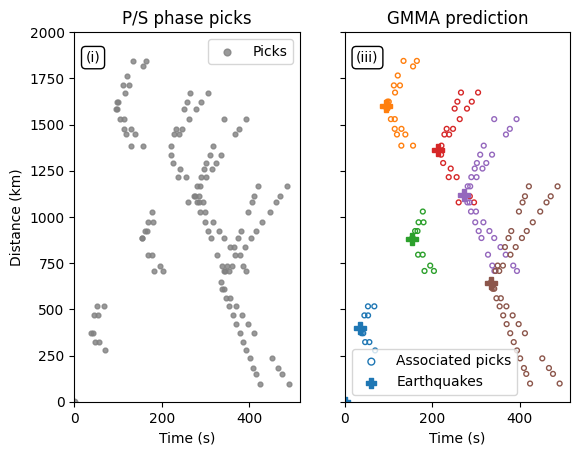

In [45]:
data = np.hstack([phase_time, phase_amp])
phase_time_range = np.max(phase_time) - np.min(phase_time)
phase_amp_range = np.max(phase_amp) - np.min(phase_amp)


# Fit a Gaussian mixture with EM 
dummy_prob = 1/((2*np.pi)**(data.shape[-1]/2) * 2)

t_start = time.time()

num_event_loc_init = 3
num_event_init = min(int(len(data)/min(num_station, 20) * 3), len(data))


centers_init = np.vstack([np.vstack([np.ones(num_event_init//num_event_loc_init) * x, np.linspace(data[:,0].min(), data[:,0].max(), num_event_init//num_event_loc_init)]).T
                          for x in np.linspace(np.min(station_loc), np.max(station_loc), num_event_loc_init+2)[1:-1]])
if use_amplitude:
    centers_init = np.hstack([centers_init, 1.0 * np.ones((len(centers_init), 1))])

if not use_amplitude:
    covariance_prior = np.array([[1]]) 
    data = data[:,0:1]
else:
    covariance_prior = np.array([[1,0], [0,1]]) 

gmm = BayesianGaussianMixture(n_components=num_event_init, 
                                      station_locs=phase_loc, 
                                      phase_type=phase_type,
                                      weight_concentration_prior = 1/num_event_init,
                                      covariance_prior = covariance_prior,
                                      init_params="centers",
                                      centers_init=centers_init.copy(),
                                      loss_type="l1",
                                    #   max_covar=10**2,
                                      ).fit(data)

# gmm = GaussianMixture(n_components=num_event_init,
#                               station_locs=phase_loc, 
#                               phase_type=phase_type, 
#                               init_params="centers",
#                               centers_init=centers_init.copy(), 
#                               loss_type="l1",
#                               max_covar=10,
#                             #   dummy_comp=True, 
#                             #   dummy_prob=0.01,
#                               ).fit(data)

t_end = time.time()
print(f"GMMA time = {t_end - t_start}")

pred = gmm.predict(data) 
prob = gmm.predict_proba(data)
score = gmm.score_samples(data)
prob_eq = prob.mean(axis=0)
std_eq = gmm.covariances_

min_picks = min(num_station, 6)
filtered_idx = np.array([True if len(data[pred==i, 0]) >= min_picks else False for i in range(len(prob_eq))]) 
#& (np.max(std_eq,axis=(1,2)) < 30) # & (std_eq < 10) #& (prob_eq > 1/num_event_init)
filtered_idx = np.arange(len(prob_eq))[filtered_idx]

marker_size = 10

#################### plot results ##############################
plt.figure()
plt.subplot(121)
if use_amplitude:
    plt.scatter(phase_time, phase_loc, s=(4**np.array(phase_amp))*1e3, color="grey",  marker="o", alpha=0.8)
else:
    plt.scatter(phase_time, phase_loc, s=12, color="grey",  marker="o", alpha=0.8)
plt.scatter(-1, -1, s=24, color="grey",  marker="o", alpha=0.8, label="Picks")
plt.xlim(left=0)
plt.ylim(xlim)
ylim_ = plt.ylim()
xlim_ = plt.xlim()
plt.ylabel("Distance (km)")
plt.xlabel("Time (s)")
plt.legend()
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize="medium", fontweight="normal", bbox=box)
plt.title("P/S phase picks")

plt.subplot(122)
colors = defaultdict(int)
idx = np.argsort(gmm.centers_[:, 1])
dum = 0
print("Associated events:")
for i in idx:
    if i in filtered_idx:
        if not use_amplitude:
            plt.scatter(data[(pred==i), 0], phase_loc[(pred==i), 0], color=f"C{dum}", s=12, marker='o', facecolors='none')
            plt.plot(gmm.centers_[i, 1], gmm.centers_[i, 0], "P", c=f"C{dum}", markersize=8)
            print(f"loc={gmm.centers_[i, 0]:.1f}\tt0={gmm.centers_[i, 1]:.1f}\tsigma11={std_eq[i,0,0]:.3f}")
        else:
            plt.scatter(data[(pred==i), 0], phase_loc[(pred==i), 0], color=f"C{dum}", s=4**(data[(pred==i), 1])*1e3, marker='o', facecolors='none')
            plt.scatter(gmm.centers_[i, 1], gmm.centers_[i, 0], color=f"C{dum}", s=4**gmm.centers_[i, 2]*3, marker="P")
            print(f"loc={gmm.centers_[i, 0]:.1f}\tt0={gmm.centers_[i, 1]:.1f}\tmag={gmm.centers_[i, 2]:.1f}\tsigma11={std_eq[i,0,0]:.3f}")
        dum += 1
plt.scatter(-1, -1, s=24, color="C0",  marker="o", facecolors='none', label="Associated picks")
plt.scatter(-1, -1, s=48, color="C0", marker="P", label="Earthquakes")
plt.xlim(xlim_)
plt.ylim(ylim_)
plt.xlabel("Time (s)")
plt.gca().yaxis.set_ticklabels([])
plt.legend()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize="medium", fontweight="normal", bbox=box)
plt.title("GMMA prediction")
plt.show()